# Run vs Pass classificated based on play summary data

In [ ]:
import pandas as pd

plays_df = pd.read_csv('/content/drive/MyDrive/dsf/project/plays.csv')

plays_df['isDropback'] = plays_df['isDropback'].astype(bool)

plays_df['contains_pass'] = plays_df['playDescription'].str.contains('pass', case=False, na=False)

total_is_dropback_true = plays_df['isDropback'].sum()

description_with_pass = len(plays_df[(plays_df['contains_pass'] == True)])

dropback_with_pass = plays_df[(plays_df['isDropback'] == True) & (plays_df['contains_pass'] == True)]

count_dropback_with_pass = len(dropback_with_pass)

percentage_with_pass = (count_dropback_with_pass / total_is_dropback_true) * 100

print(f"Total plays where isDropback = True: {total_is_dropback_true}")
print(f"Total plays where playDescription contains 'pass': {description_with_pass}")
print(f"Plays where isDropback = True and playDescription contains 'pass': {count_dropback_with_pass}")
print(f"Percentage of isDropback = True plays with 'pass' in playDescription: {percentage_with_pass:.2f}%")

Total plays where isDropback = True: 9736
Total plays where playDescription contains 'pass': 8719
Plays where isDropback = True and playDescription contains 'pass': 8706
Percentage of isDropback = True plays with 'pass' in playDescription: 89.42%


In [ ]:
plays_df= plays_df.dropna(subset=['isDropback'])

In [ ]:
nan_percentages = (plays_df.isnull().sum() / len(plays_df)) * 100

nan_summary = pd.DataFrame({
    "Column": nan_percentages.index,
    "% of NaN/Empty": nan_percentages.values
})

nan_summary_sorted = nan_summary.sort_values(by="% of NaN/Empty", ascending=True)

nan_summary_sorted.reset_index(drop=True, inplace=True)

nan_summary_sorted

,Column,% of NaN/Empty
0,gameId,0.000000
1,pff_runPassOption,0.000000
2,isDropback,0.000000
3,expectedPointsAdded,0.000000
4,visitorTeamWinProbilityAdded,0.000000
5,homeTeamWinProbabilityAdded,0.000000
6,yardsGained,0.000000
7,prePenaltyYardsGained,0.000000
8,qbKneel,0.000000
9,expectedPoints,0.000000


In [ ]:
threshold = 2

nan_percentages = (plays_df.isnull().sum() / len(plays_df)) * 100

columns_to_drop = nan_percentages[nan_percentages > threshold].index

plays_df_cleaned = plays_df.drop(columns=columns_to_drop)

In [ ]:
game_data = pd.read_csv('/content/drive/MyDrive/dsf/project/games.csv')

In [ ]:
play_data = plays_df_cleaned.merge(game_data, on='gameId')

play_data['isHomeTeam'] = play_data['possessionTeam'] == play_data['homeTeamAbbr']

play_data['preSnapPossessionTeamWinProbability'] = play_data.apply(
    lambda row: row['preSnapHomeTeamWinProbability'] if row['isHomeTeam'] else row['preSnapVisitorTeamWinProbability'], axis=1
)
play_data['preSnapPossessionTeamScore'] = play_data.apply(
    lambda row: row['preSnapHomeScore'] if row['isHomeTeam'] else row['preSnapVisitorScore'], axis=1
)
play_data['preSnapNonPossessionTeamScore'] = play_data.apply(
    lambda row: row['preSnapVisitorScore'] if row['isHomeTeam'] else row['preSnapHomeScore'], axis=1
)


In [ ]:
play_data['gameClock'] = play_data['gameClock'].apply(
    lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1])
)

In [ ]:
selected_attributes = [
    "quarter",  # Game phase affects strategy
    "down",  # Passing more common on higher downs
    "yardsToGo",  # Long yardage favors passing
    "possessionTeam",  # Offensive team tendencies
    "defensiveTeam",  # Defensive team strengths/weaknesses
    "yardlineSide",  # Field position impacts strategy
    "yardlineNumber",  # Specific yard line affects play type
    "gameClock",  # Time urgency affects play selection
    "preSnapPossessionTeamScore",  # Score differential influences strategy
    "preSnapNonPossessionTeamScore",  # Score of opponent impacts urgency
    "absoluteYardlineNumber",  # Proximity to end zone impacts decisions
    "preSnapPossessionTeamWinProbability",  # Situation importance affects calls
    "expectedPoints",  # Play value affects strategy
    "playClockAtSnap",  # Time left on play clock affects urgency
    "receiverAlignment"  # Receiver positioning hints tendencies
]

target = [ "isDropback" ]

play_data = play_data[selected_attributes + target]

In [ ]:
play_data['isDropback'] = play_data['isDropback'].replace({True: 1, False: 0})

<ipython-input-90-9dd23b15adfe>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  play_data['isDropback'] = play_data['isDropback'].replace({True: 1, False: 0})


In [ ]:
for column in play_data.columns:
    if play_data[column].dtype == 'object':
        play_data[column].fillna(play_data[column].mode()[0], inplace=True)
    else:
        play_data[column].fillna(play_data[column].median(), inplace=True)

<ipython-input-91-6b9b8fb6091c>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  play_data[column].fillna(play_data[column].median(), inplace=True)  # Median for numerical
<ipython-input-91-6b9b8fb6091c>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[c

In [ ]:
from sklearn.preprocessing import LabelEncoder

teams = ["possessionTeam", "defensiveTeam", "yardlineSide"]

label_encoder = LabelEncoder()

all_teams = pd.concat([play_data[team] for team in teams]).unique()
label_encoder.fit(all_teams)

for team in teams:
    play_data[team] = label_encoder.transform(play_data[team])

In [ ]:
receiver_alignment_encoder = LabelEncoder()

play_data["receiverAlignment"] = receiver_alignment_encoder.fit_transform(play_data["receiverAlignment"])

In [ ]:
play_data.head()

,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapPossessionTeamScore,preSnapNonPossessionTeamScore,absoluteYardlineNumber,preSnapPossessionTeamWinProbability,expectedPoints,playClockAtSnap,receiverAlignment,isDropback
0,3,1,10,6,1,6,21,114,35,17,31,0.982017,0.719313,10.0,7,1
1,4,1,10,6,8,6,8,133,17,17,18,0.575644,0.607746,9.0,7,1
2,4,3,12,12,30,12,20,120,3,17,30,0.006291,-0.291485,12.0,4,1
3,1,2,10,15,30,30,23,568,0,0,33,0.884223,4.249382,11.0,4,1
4,3,2,8,2,29,29,27,136,10,10,37,0.589629,3.928413,8.0,6,0


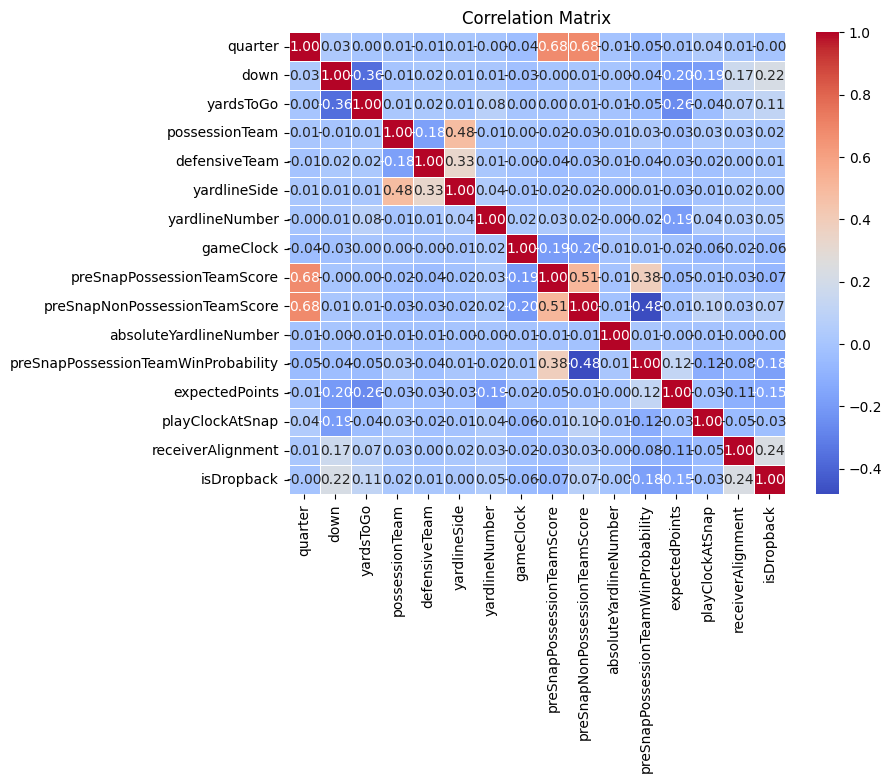

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = play_data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score


In [ ]:
X = play_data.drop(columns=['isDropback'])
y = play_data['isDropback']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

<Figure size 1200x600 with 0 Axes>

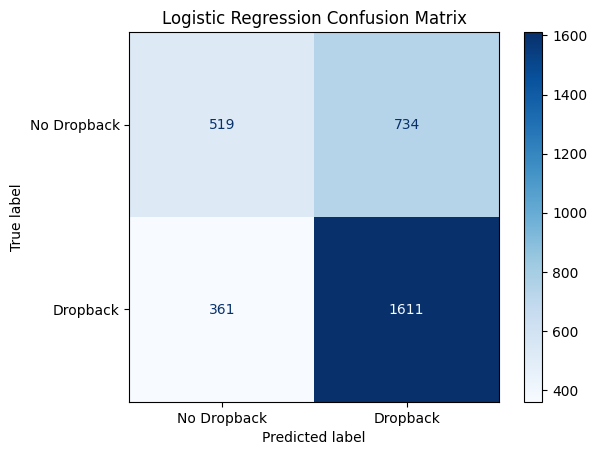

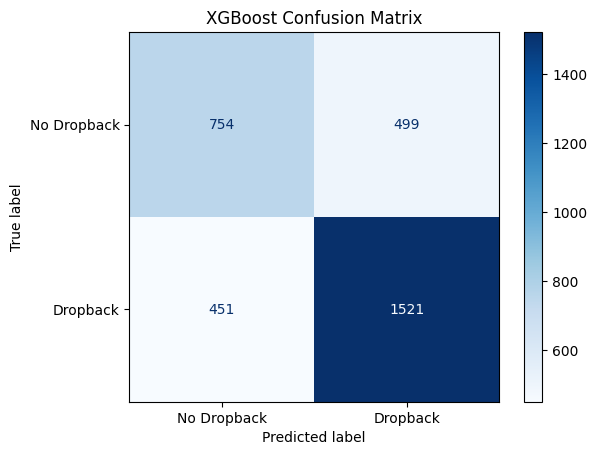

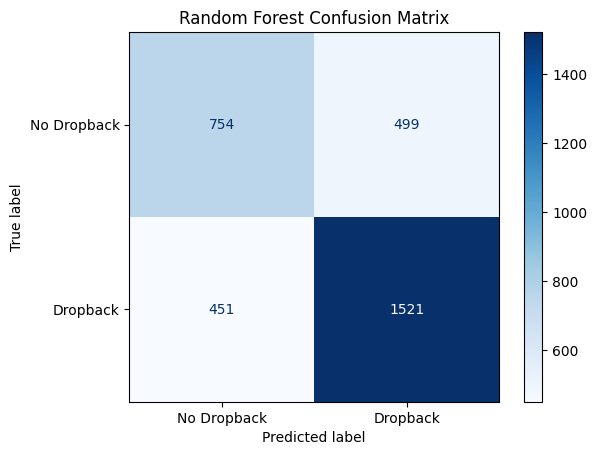

In [ ]:
y_pred_logreg = logreg.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_rf = rf.predict(X_test)

cm_logreg = confusion_matrix(y_test, y_pred_logreg)
cm_display_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=["No Dropback", "Dropback"])

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
cm_display_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["No Dropback", "Dropback"])

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Dropback", "Dropback"])

plt.figure(figsize=(12, 6))

cm_display_logreg.plot(cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')

cm_display_xgb.plot(cmap='Blues')
plt.title('XGBoost Confusion Matrix')

cm_display_xgb.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')

plt.show()

In [ ]:
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Logistic Regression Accuracy: 0.6605
XGBoost Accuracy: 0.7054
Random Forest Accuracy: 0.7085
